# Graph colouring

Graph colouring is a fundamental problem in computer science and mathematics, with applications in many fields, such as scheduling, map coloring, and register allocation. In graph theory, a graph is a set of vertices and edges connecting them. The goal of graph colouring is to assign colours to the vertices of a graph, subject to certain constraints.    

One of the most well-known constraints in graph colouring (and the one that is considered below) is the restriction that __adjacent vertices must have different colours__. This is commonly known as the vertex colouring problem.

In simple terms:
1. There is a graph. It is up to the user to decide how many vertices and edges it has.
2. The goal is to colour its vertices in a way that no adjacent vertices have the same colour.
3. It is best to minimize the computing time and number of used colours.   

The minimum number of colors in a proper (stated in the point 2.) coloring of a graph G is called the **chromatic number** of G. Since there is no trivial formula to determine such number, I won't be checking whether the solution is using that exact ideal number, but I will construct the algorithm to seek to minimize it.    

The **main goal** of this project is to create a model, that, given a graph, will implement its proper coloring. 

---

### Importing libraries and fetching a pleasant colour palette

In [107]:
import networkx as nx
import numpy as np
import random
from collections import Counter
import time

import pygad
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mp

I have prepared 20 colours - it is enough for the graphs I am considering in this project, although it won't be for more complex ones.    
If a user wants to process such graphs, either:
* this color palette should be updated with more colours
* in function graph_draw, when plotting nodes, omit 'cmap' parameter; this will conclude in using a default palette with more colours      

Rather than an issue, this is purely a case of the aesthetics.

In [2]:
colours = ['#D95555', '#95DE8E', '#57A91A', '#72A3B3', '#2B6B80', '#E0969F', '#7E53AD', '#3A007A', '#E5CA85', '#AD771F',
            '#9C3C3C', '#5C8758', '#25480C', '#405C65', '#163640', '#9E686E', '#543575', '#1D003E', '#948357', '#5F4112']

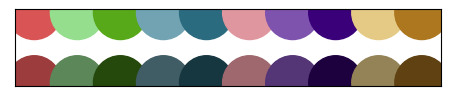

In [3]:
fig, ax = plt.subplots(figsize=(5.5,1))
ax.scatter([i for i in range(10)], [1 for i in range(10)], color = colours[:10], s=1500)
ax.scatter([i for i in range(10)], [0 for i in range(10)], color = colours[10:20], s=1500)
ax.set_xticks([])
ax.set_yticks([])
# creating a colormap
my_cmap = ListedColormap(colours) 

### Creation of an exemplary graph
To create and plot graphs I will use library networkx.   
Function __erdos_renyi_graph__ from nx.generators.random_graphs creates a graph based on two inputs:
1. __Number of vertices__
2. __Probability of connecting one vertex to another__; for example: if that probability is set to 0.75, that will effect in drawing on average 3 edges out of 4

My assumption is that the computing time will most likely escalate with higher complexity of the graph (one that has not only more nodes, but also more edges) - which is why I will use a fixed probability of connecting vertices, equal to 0.5.

In [4]:
n_verts = 10   # nr of vertices
p = 0.5 # probability of creating an edge
g = nx.generators.random_graphs.erdos_renyi_graph(n_verts, p)

print('Every vertex has an index:', g.nodes)
print('\nAnd every edge points to the indices of vertices its connecting:', g.edges)

Every vertex has an index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

And every edge points to the indices of vertices its connecting: [(0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (1, 2), (1, 4), (1, 5), (1, 8), (2, 3), (2, 5), (2, 6), (2, 8), (2, 9), (3, 4), (3, 8), (3, 9), (4, 6), (4, 7), (4, 9), (5, 6), (5, 7), (5, 8), (7, 8), (7, 9), (8, 9)]


Note: every instance of a connection appears once - if node ***a*** is connected to node ***b***, then there will be only a pair (a,b) **or** (b,a), not both of them.

### Defining gene space and chromosomes
The gene space will consist of indices of colours in the chosen color palette, which means that chromosome (solution) will point to the colour that is assigned to each vertex that is positioned on the list.

In [5]:
gene_space = [i for i in range(20)]
num_genes = n_verts

### Defining functions

This function **assigns colours to graph vertices** based on the colour indices in the solution and stores them in a list:

In [6]:
def assign_colours(solution):
    nodes_colours = []
    for i in solution:
        nodes_colours.append(colours[int(i)])
        
    return nodes_colours

This function **draws** coloured nodes and edges based on the solution:

In [7]:
def graph_draw(nodes_colours, edges):     
    # coloring edges according to whether they connect two different-coloured nodes: red if they do, black if they don't
    edges = list(edges)
    edges_colours = []
    edges_widths = []
    for i in range(len(edges)):
        if nodes_colours[int(edges[i][0])] == nodes_colours[int(edges[i][1])]:
            edges_colours.append('red')
            edges_widths.append(2)
        else:
            edges_colours.append('black')
            edges_widths.append(.5)
    
    # setting a nice, clear layout of the graph
    pos = nx.shell_layout(g)
            
    nx.draw_networkx_nodes(g, node_color = nodes_colours, pos=pos, cmap=my_cmap)
    nx.draw_networkx_edges(g, edge_color = edges_colours, pos=pos, width = edges_widths)

This function is the base of the learning process for the genetic algorithm; it gives two **punishments**:
* for the **same colour** on two neighbouring nodes
* for using **more than less** colours in general; the used formula is:
$\frac{1}{v - c}$, where    
$v$ - number of **vertices in the graph**       
$c$ - number of **coloured vertices** in the solution    
If $v$ and $c$ are equal, then value 1 is assigned

In [8]:
def punishments(edges, nodes, nodes_colours):
    edges = list(edges)
    neigh_pun = 0
    col_pun = 0
    for i in range(len(edges)):
        if nodes_colours[int(edges[i][0])] == nodes_colours[int(edges[i][1])]:
            neigh_pun += 1
    
    nodes = list(nodes)
    n_verts = len(nodes) # number of vertices in the graph 
    n_col_verts = len(Counter(nodes_colours).keys()) # number of coloured used
    
    if n_verts == n_col_verts:
        col_pun = 1
    else:
        col_pun = 1/(n_verts-n_col_verts)
    
    return neigh_pun, col_pun

---
### Creating the genetic algorithm
The **fitness function** will work in a punishment oriented way: 
* the fitness value starts at **50** 
* every occurence of **same-coloured neighbouring nodes** in the solution is summed up, multiplied by a coefficient and **subtracted** from the fitness value 
* what also gets multiplied by a coefficient and subtracted from the fitness value is ${\frac{1}{v - c}}$, as stated before

In [9]:
def fitness_func(solution, solution_idx):
    neigh_pun, col_pun = punishments(g.edges, g.nodes, solution)
    
    a = 50
    b = .0000001 # setting this coefficient to a very low value to see how the model will perform
    c = 5
    fitness = a - b*neigh_pun - c*col_pun
    
    return fitness

#### Setting basic parameters for the algorithm

Parameters of the best solution : [ 1.  3.  1.  3. 11. 11.  3.  1. 11.  3.]
Fitness value of the best solution = 49.28571408571428
Number of generations passed is 50


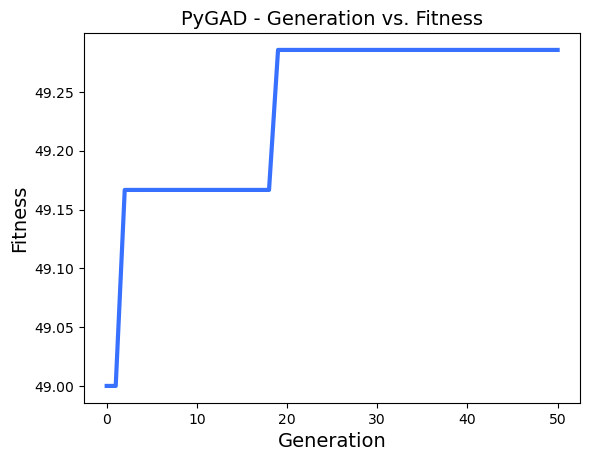

In [10]:
fitness_function = fitness_func

sol_per_pop = 100

num_parents_mating = 50
num_generations = 50
keep_parents = 5

parent_selection_type = 'sss'
crossover_type = 'single_point'
mutation_type = 'random'
mutation_percent_genes = 15

ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       save_solutions=False)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))
ga_instance.plot_fitness()

plt.show(block=True) # this blocks displaying last plot twice

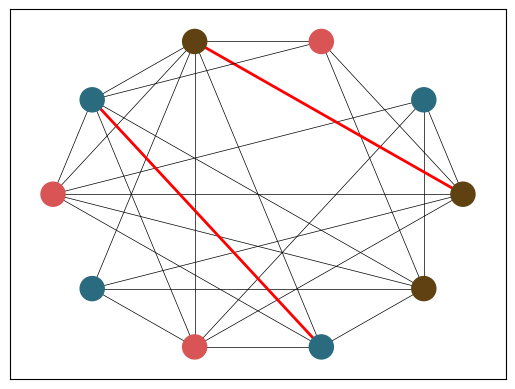

In [11]:
graph_draw(solution, g.edges)

As the algorithm was mainly taught to avoid using too many colours but it wasn't taught well enough to pay attention to colouring neighbouring nodes, it didn't solve the problem.    
**Let's try manipulating the coefficients in the fitness function:** 

In [12]:
def fitness_func(solution, solution_idx):
    neigh_pun, col_pun = punishments(g.edges, g.nodes, solution)
    
    a = 50
    b = 1
    c = 5
    fitness = a - b*neigh_pun - c*col_pun
    
    return fitness

Parameters of the best solution: [13.  1. 13. 19. 16. 19.  1. 13. 16.  1.]
Fitness value of the best solution = 49.166666666666664
Number of used colours:  4
Number of generations passed is 50


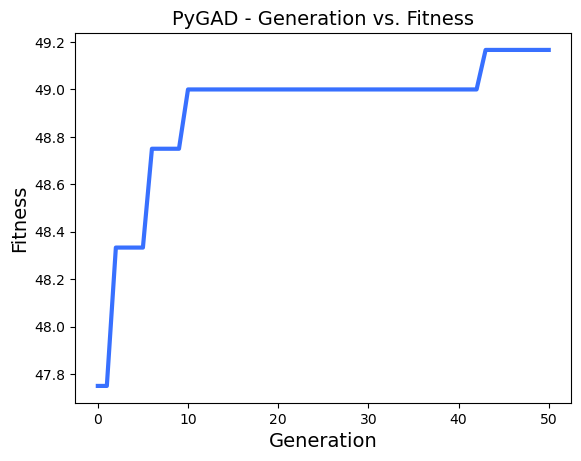

In [13]:
fitness_function = fitness_func

ga_instance = pygad.GA(gene_space=gene_space,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       save_solutions=False)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution: {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print('Number of used colours: ', len(Counter(solution).keys()))

print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))
ga_instance.plot_fitness()

plt.show(block=True) # this blocks displaying last plot twice

The fitness value of the solution has reached very quickly a value quite close to 50, which means that it could be a proper one.   

**Let's see it by plotting the coloured graph:**

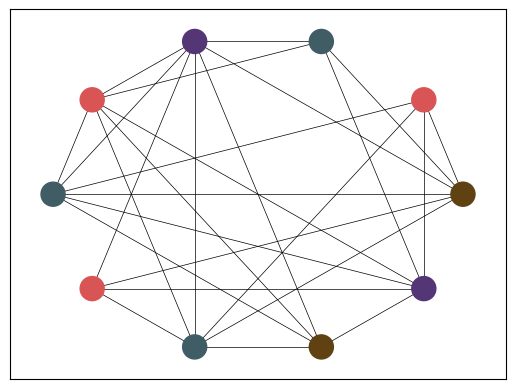

In [14]:
graph_draw(solution, g.edges)

**The algorithm has found a solution!** But will it work on other graphs?

---
### Testing the algorithm on different-sized graphs

In [110]:
# placeholders for graphs of each complexity
g_small = [] 
g_medium = []
g_large = []
# number of nodes for graphs from each group
s_v = 7
m_v = 16
l_v = 54

for i in range(3):
    g_small.append(nx.generators.random_graphs.erdos_renyi_graph(s_v, p))
    g_medium.append(nx.generators.random_graphs.erdos_renyi_graph(m_v, p))
    g_large.append(nx.generators.random_graphs.erdos_renyi_graph(l_v, p))

**Strategy for choosing the parameters for the algorithm:**
* the **population** is set according to the chromosome length; assumingly good proportion is 5*(chromosome length)
* **number of parents mating** is 1/2 of the population quantity and **parents kept** is 1/20 of the latter; that is to ensure more dynamic evolution
* the **crossover type** has been set to scattered to get more fluidity in choosing the colours for the nodes
* algorithm will stop after having passed (chromosome length) iterations and having no progress in te fitness value - **stop_criteria** will be set to  'saturate_[(chromosome length) + some operations regarding it]'
* **number of mutated genes** is chosen to equal 1 regardless of the complexity of a graph; I don't think that it will be that valuable for the algorithm

#### Small graphs

In [111]:
num_genes = s_v

sol_per_pop = num_genes*5

num_parents_mating = sol_per_pop//2
num_generations = 75
keep_parents = sol_per_pop//20

crossover_type = 'scattered'

mutation_num_genes=1

stop_criteria = 'saturate_'+str(num_genes*2)

Parameters of the best solution : [12.  0. 14. 19. 12. 12.  0.]
Fitness value of the best solution = 48.333333333333336
Number of generations passed is 16


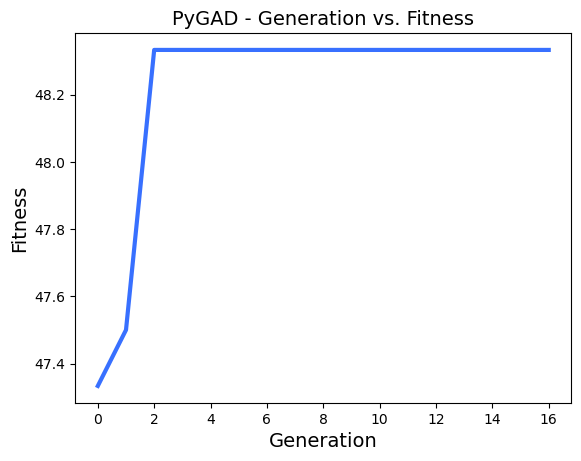

Wrong connections: 0
Used colours: 4
Number of nodes in the graph: 7
Number of edges in the graph: 11


~.~

Parameters of the best solution : [ 7.  7. 19.  8. 19.  9.  8.]
Fitness value of the best solution = 48.333333333333336
Number of generations passed is 26


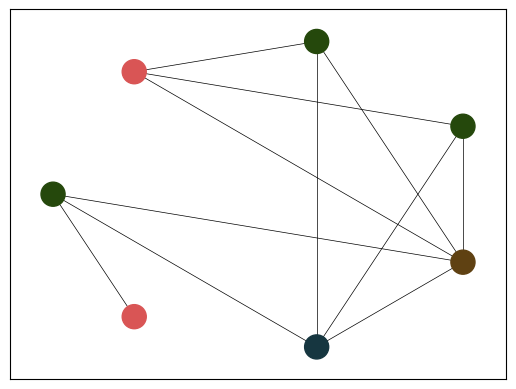

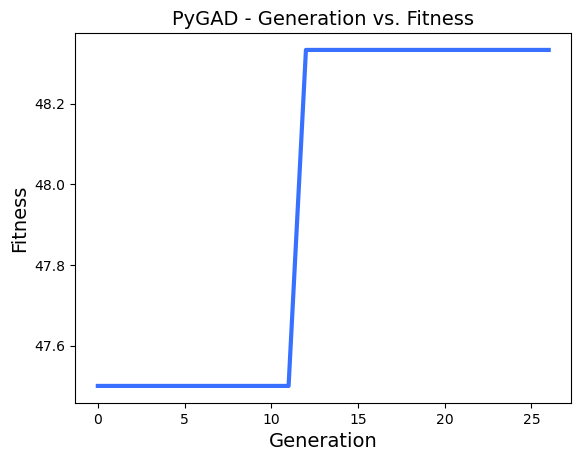

Wrong connections: 0
Used colours: 4
Number of nodes in the graph: 7
Number of edges in the graph: 12


~.~

Parameters of the best solution : [17. 15. 10. 10. 17. 10. 15.]
Fitness value of the best solution = 48.75
Number of generations passed is 27


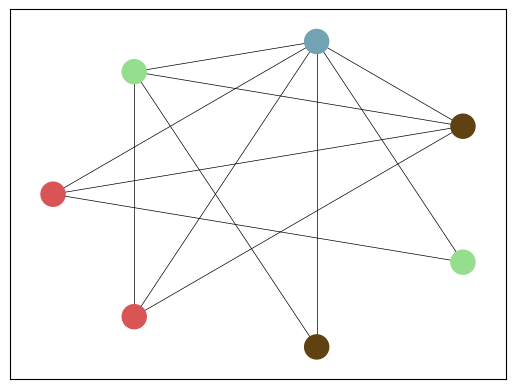

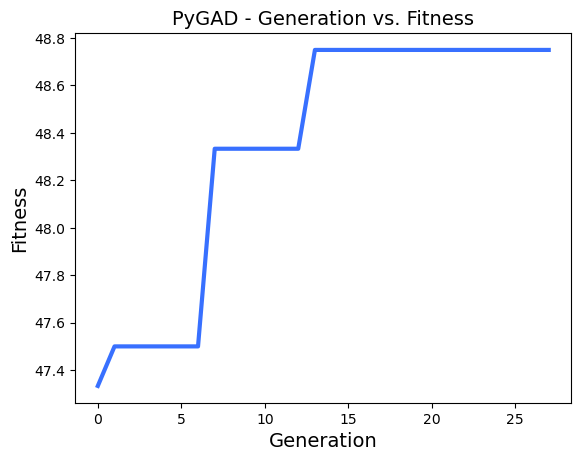

Wrong connections: 0
Used colours: 3
Number of nodes in the graph: 7
Number of edges in the graph: 11


~.~



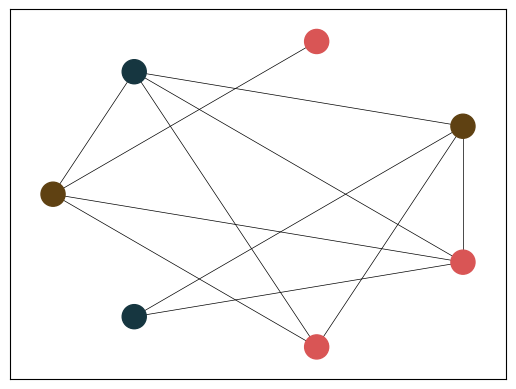

In [112]:
for i in range(3):
    g = g_small[i]

    ga_instance = pygad.GA(gene_space=gene_space,
                   num_generations=num_generations,
                   num_parents_mating=num_parents_mating,
                   fitness_func=fitness_function,
                   sol_per_pop=sol_per_pop,
                   num_genes=num_genes,
                   parent_selection_type=parent_selection_type,
                   keep_parents=keep_parents,
                   crossover_type=crossover_type,
                   mutation_type=mutation_type,
                   mutation_num_genes=mutation_num_genes,
                   stop_criteria = stop_criteria)
    
    ga_instance.run()
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Parameters of the best solution : {solution}".format(solution=solution))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

    print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))
    ga_instance.plot_fitness()

    graph_draw(solution, g.edges)

    w_con, u_col = punishments(g.edges, g.nodes, solution) 
    # function 'punishments' doesn't return the number of used colors itself, but the formula used as algorithm's punishment - 
    # it is fetched here to find the number of wrong connections in the graph; the number of used colors is defined below:
    u_col = len(Counter(solution).keys())

    print('Wrong connections:', w_con)
    print('Used colours:', u_col)
    print('Number of nodes in the graph:', len(list(g.nodes)))
    print('Number of edges in the graph:', len(list(g.edges)))
    print('\n\n~.~\n')

#### Medium graphs

In [113]:
num_genes = m_v

sol_per_pop = num_genes*5

num_parents_mating = sol_per_pop//2

keep_parents = sol_per_pop//20

stop_criteria = 'saturate_'+str(num_genes)

Parameters of the best solution : [ 4.  4.  4.  3. 10. 10. 18.  6. 10. 18.  3.  4.  8. 18.  3.  6.]
Fitness value of the best solution = 49.5
Number of generations passed is 50


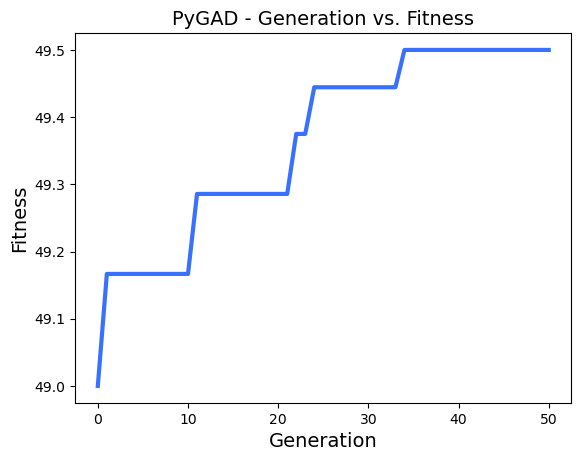

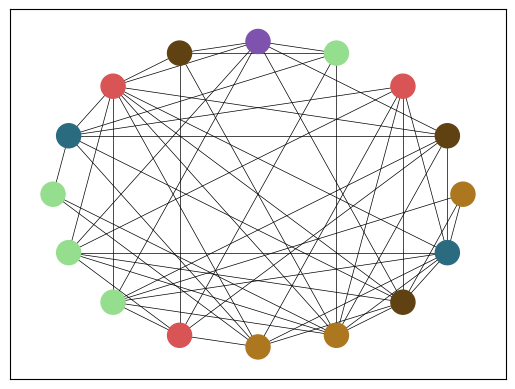

Wrong connections: 0
Used colours: 6
Number of nodes in the graph: 16
Number of edges in the graph: 54


~.~

Parameters of the best solution : [14. 14. 10. 15. 14. 10.  4. 15.  4. 16.  9. 15. 14. 10.  8. 15.]
Fitness value of the best solution = 49.44444444444444
Number of generations passed is 40


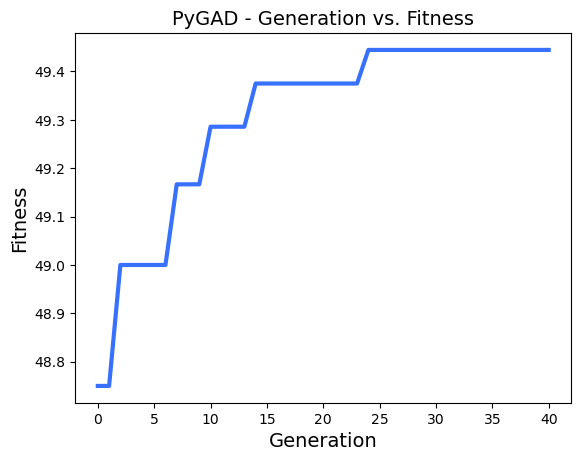

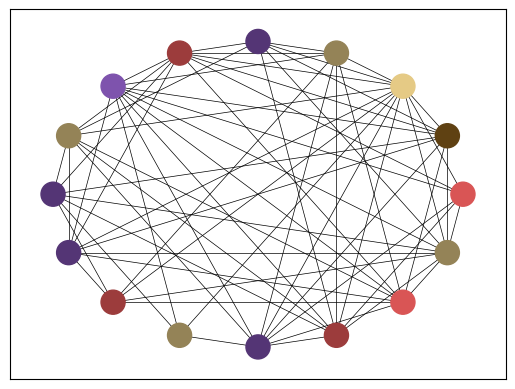

Wrong connections: 0
Used colours: 7
Number of nodes in the graph: 16
Number of edges in the graph: 66


~.~

Parameters of the best solution : [ 4.  9.  3.  1. 12. 13. 13. 12. 11.  9.  0.  9.  9.  4.  9.  0.]
Fitness value of the best solution = 49.375
Number of generations passed is 34


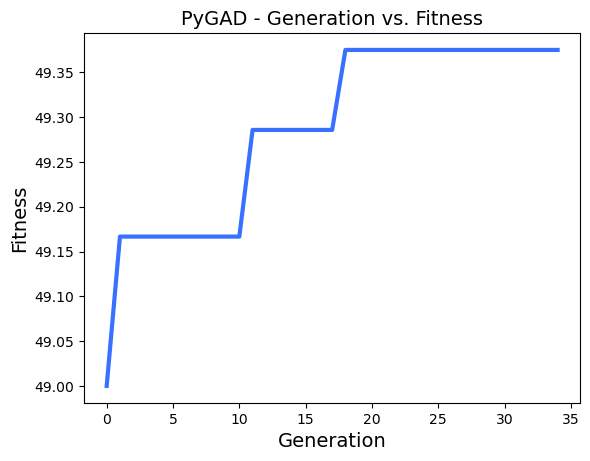

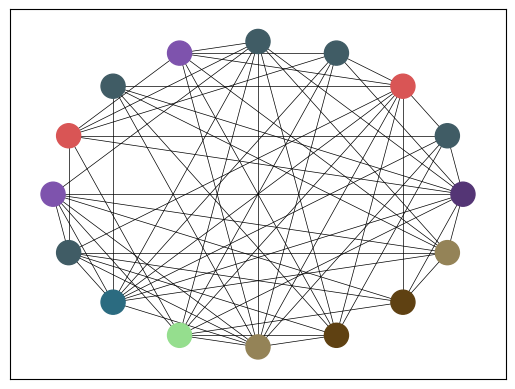

Wrong connections: 0
Used colours: 8
Number of nodes in the graph: 16
Number of edges in the graph: 65


~.~



In [114]:
for i in range(3):
    g = g_medium[i]

    ga_instance = pygad.GA(gene_space=gene_space,
                   num_generations=num_generations,
                   num_parents_mating=num_parents_mating,
                   fitness_func=fitness_function,
                   sol_per_pop=sol_per_pop,
                   num_genes=num_genes,
                   parent_selection_type=parent_selection_type,
                   keep_parents=keep_parents,
                   crossover_type=crossover_type,
                   mutation_type=mutation_type,
                   mutation_num_genes=mutation_num_genes,
                   stop_criteria = stop_criteria)
    
    ga_instance.run()
        
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Parameters of the best solution : {solution}".format(solution=solution))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

    print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))
    ga_instance.plot_fitness()

    graph_draw(solution, g.edges)
    plt.show(block=False) 

    w_con, u_col = punishments(g.edges, g.nodes, solution)
    u_col = len(Counter(solution).keys())

    print('Wrong connections:', w_con)
    print('Used colours:', u_col)
    print('Number of nodes in the graph:', len(list(g.nodes)))
    print('Number of edges in the graph:', len(list(g.edges)))
    print('\n\n~.~\n')

#### Large graphs

In [115]:
num_genes = l_v

sol_per_pop = num_genes*5

num_parents_mating = int(np.floor(sol_per_pop/2))

keep_parents = int(np.floor(sol_per_pop/20))

stop_criteria = 'saturate_'+str(num_genes//3)

Parameters of the best solution : [14.  0. 16. 18.  9.  2.  7.  9.  5.  8.  1.  1. 16.  2.  6.  0. 17. 15.
  5. 19. 16.  6.  7.  2.  9. 14.  3. 11.  5. 19. 14.  9. 19. 14.  8. 15.
  2.  1. 17. 14.  1. 11.  9.  8. 14. 19.  7. 18. 16.  0. 15. 10. 17.  1.]
Fitness value of the best solution = 49.86486486486486
Number of generations passed is 75


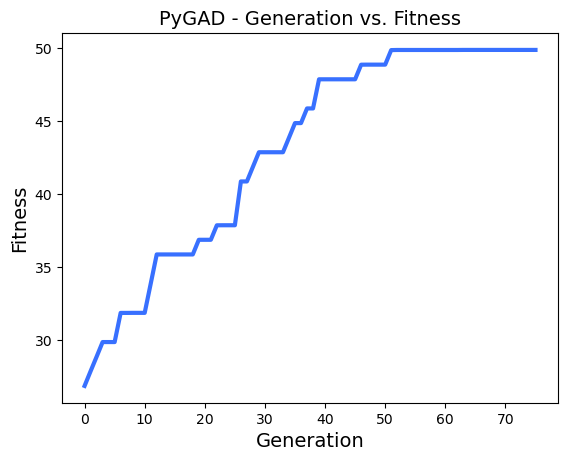

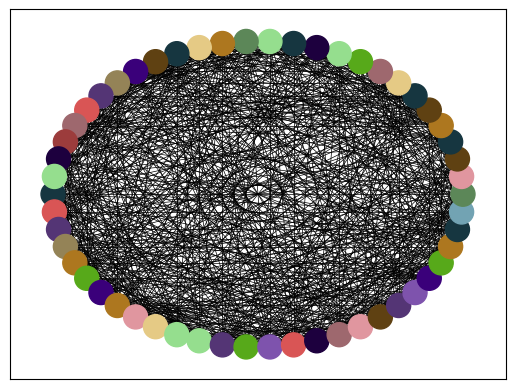

Wrong connections: 0
Used colours: 17
Number of nodes in the graph: 54
Number of edges in the graph: 728


~.~

Parameters of the best solution : [19. 10.  2.  4.  6.  8.  9. 15.  8.  6.  0.  5.  7. 14. 18.  7.  6.  7.
  5. 11. 17. 17.  7.  5.  7.  3.  6.  8. 15. 13.  4. 14. 16. 11.  4. 19.
 11. 18.  4.  2.  5. 19.  3. 18. 19.  2.  6.  3. 11.  9. 14. 11. 18. 13.]
Fitness value of the best solution = 49.861111111111114
Number of generations passed is 62


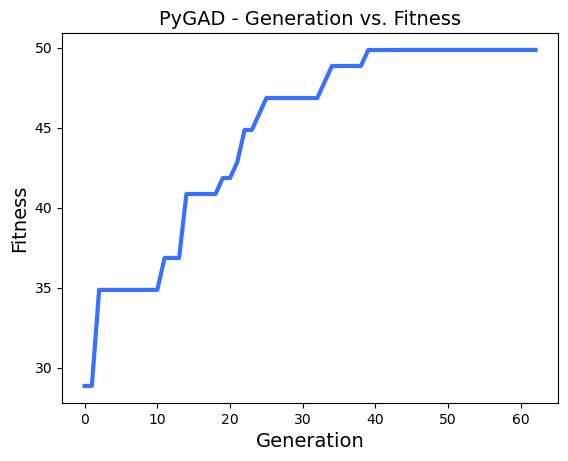

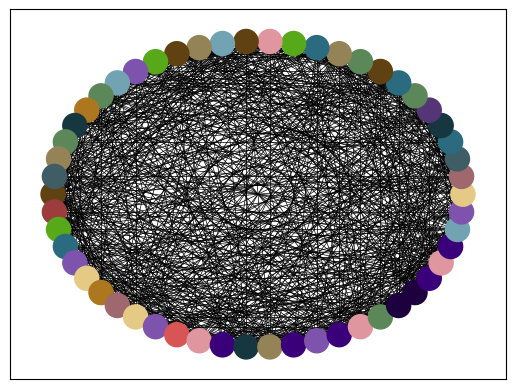

Wrong connections: 0
Used colours: 18
Number of nodes in the graph: 54
Number of edges in the graph: 711


~.~

Parameters of the best solution : [19.  1.  1. 18.  9.  2.  2. 13. 17.  8. 16. 14.  3. 18.  3. 15.  8.  1.
 16. 10. 11. 19.  5.  4.  6. 16. 12.  5. 17. 16.  3.  9. 10. 13.  4. 12.
 17. 19. 18.  8.  0. 10.  6.  9.  0.  0.  6.  2. 13.  0.  4. 16. 11. 14.]
Fitness value of the best solution = 49.857142857142854
Number of generations passed is 56


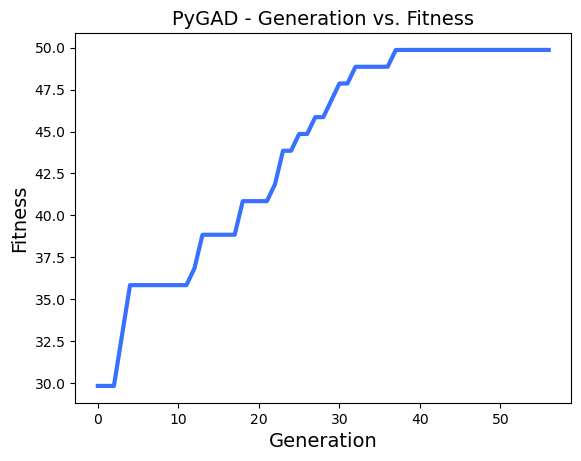

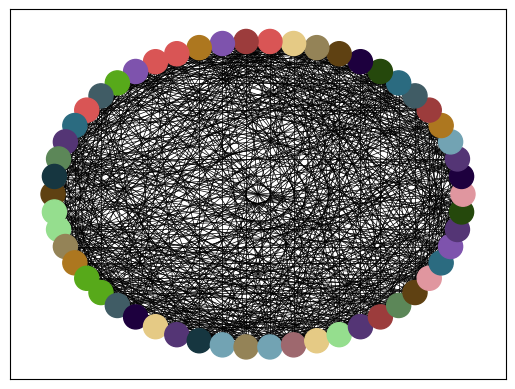

Wrong connections: 0
Used colours: 19
Number of nodes in the graph: 54
Number of edges in the graph: 695


~.~



In [116]:
for i in range(3):
    g = g_large[i]

    ga_instance = pygad.GA(gene_space=gene_space,
                   num_generations=num_generations,
                   num_parents_mating=num_parents_mating,
                   fitness_func=fitness_function,
                   sol_per_pop=sol_per_pop,
                   num_genes=num_genes,
                   parent_selection_type=parent_selection_type,
                   keep_parents=keep_parents,
                   crossover_type=crossover_type,
                   mutation_type=mutation_type,
                   mutation_num_genes=mutation_num_genes,
                   stop_criteria = stop_criteria)
    
    ga_instance.run()
        
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Parameters of the best solution : {solution}".format(solution=solution))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

    print("Number of generations passed is {generations_completed}".format(generations_completed=ga_instance.generations_completed))
    ga_instance.plot_fitness()

    graph_draw(solution, g.edges)
    plt.show(block=False) 

    w_con, u_col = punishments(g.edges, g.nodes, solution)
    u_col = len(Counter(solution).keys())

    print('Wrong connections:', w_con)
    print('Used colours:', u_col)
    print('Number of nodes in the graph:', len(list(g.nodes)))
    print('Number of edges in the graph:', len(list(g.edges)))
    print('\n\n~.~\n')

Every graph out of **these nine** has been **coloured properly**, which could point to algorithm's high efficiency.   
However, it could be useful to check it on more inputs. 
---

### Algorithm efficiency and computing time analysis    
There will be 100 (or 15) algorithms for each of the three complexity groups;
* efficiency (in each category) will be calculated by dividing the number of algorithms that solved the problem by a number of total iterations 
* the ones that will solve the problem will be taken into consideration when analyzing computing time

#### Efficiency

In [117]:
# placeholders for measured times of solution finding 
small_times = []
medium_times = []
large_times = []

# lists of indices of properly coloured graphs in each of the group
s_good_ind = []
m_good_ind = []
l_good_ind = []

Small graphs:

In [118]:
num_genes = s_v

sol_per_pop = num_genes*5

num_parents_mating = sol_per_pop//2
num_generations = 75
keep_parents = sol_per_pop//20

crossover_type = 'scattered'

mutation_num_genes=1

stop_criteria = 'saturate_'+str(num_genes*2)


for i in range(100):
    g = g_small[random.choice([0,1,2])]

    ga_instance = pygad.GA(gene_space=gene_space,
                   num_generations=num_generations,
                   num_parents_mating=num_parents_mating,
                   fitness_func=fitness_function,
                   sol_per_pop=sol_per_pop,
                   num_genes=num_genes,
                   parent_selection_type=parent_selection_type,
                   keep_parents=keep_parents,
                   crossover_type=crossover_type,
                   mutation_type=mutation_type,
                   mutation_num_genes=mutation_num_genes,
                   stop_criteria = stop_criteria)
    start = time.time()
    ga_instance.run()
    end = time.time()
    
    small_times.append(end - start)
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    w_con, u_col = punishments(g.edges, g.nodes, solution)
    
    if w_con == 0: s_good_ind.append(i)
        
print('Number of properly colours graphs: ',len(s_good_ind),' out of 100.')

Number of properly colours graphs:  100  out of 100.


Medium graphs:

In [119]:
num_genes = m_v

sol_per_pop = num_genes*5

num_parents_mating = sol_per_pop//2
num_generations = 75
keep_parents = sol_per_pop//20

crossover_type = 'scattered'

mutation_num_genes=1

stop_criteria = 'saturate_'+str(num_genes)


for i in range(100):
    g = g_medium[random.choice([0,1,2])]

    ga_instance = pygad.GA(gene_space=gene_space,
                   num_generations=num_generations,
                   num_parents_mating=num_parents_mating,
                   fitness_func=fitness_function,
                   sol_per_pop=sol_per_pop,
                   num_genes=num_genes,
                   parent_selection_type=parent_selection_type,
                   keep_parents=keep_parents,
                   crossover_type=crossover_type,
                   mutation_type=mutation_type,
                   mutation_num_genes=mutation_num_genes,
                   stop_criteria = stop_criteria)
    start = time.time()
    ga_instance.run()
    end = time.time()
    
    medium_times.append(end - start)
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    w_con, u_col = punishments(g.edges, g.nodes, solution)
    
    if w_con == 0: m_good_ind.append(i)
        
print('Number of properly colours graphs: ',len(m_good_ind),' out of 100.')

Number of properly colours graphs:  100  out of 100.


Large graphs:    
The number of iterations is lower (100 -> 15), because, as it can be seen a bit below, the computing time is quite high. 

In [120]:
num_genes = l_v

sol_per_pop = num_genes*5

num_parents_mating = sol_per_pop//2
num_generations = 75
keep_parents = sol_per_pop//20

crossover_type = 'scattered'

mutation_num_genes=1

stop_criteria = 'saturate_'+str(num_genes//3)


for i in range(15):
    g = g_large[random.choice([0,1,2])]

    ga_instance = pygad.GA(gene_space=gene_space,
                   num_generations=num_generations,
                   num_parents_mating=num_parents_mating,
                   fitness_func=fitness_function,
                   sol_per_pop=sol_per_pop,
                   num_genes=num_genes,
                   parent_selection_type=parent_selection_type,
                   keep_parents=keep_parents,
                   crossover_type=crossover_type,
                   mutation_type=mutation_type,
                   mutation_num_genes=mutation_num_genes,
                   stop_criteria = stop_criteria)
    start = time.time()
    ga_instance.run()
    end = time.time()
    
    large_times.append(end - start)
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    w_con, u_col = punishments(g.edges, g.nodes, solution)
    
    if w_con == 0: l_good_ind.append(i)
        
print('Number of properly colours graphs: ',len(l_good_ind),' out of 15.')

Number of properly colours graphs:  15  out of 15.


#### Computing time

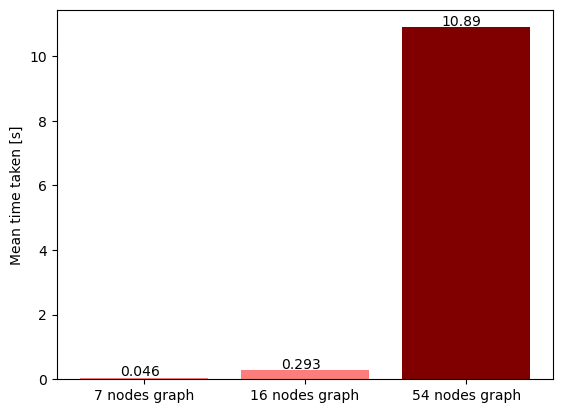

In [121]:
plt.figure()

# fetching times of algorithm instances that properly coloured the graphs
g_small_times =[small_times[ind] for ind in s_good_ind]
g_medium_times = [medium_times[ind] for ind in m_good_ind]
g_large_times = [large_times[ind] for ind in l_good_ind]

# getting mean values of them
times_means = [np.mean(g_small_times), np.mean(g_medium_times), np.mean(g_large_times)]

# preparing colour palette ready to be scaled to mean times
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)
 

plt.bar([str(s_v)+' nodes graph', str(m_v)+' nodes graph', str(l_v)+' nodes graph'], times_means, align="center",
    color=color_map(data_normalizer(times_means)))
plt.ylabel('Mean time taken [s]')
for i in range(3):
    plt.annotate(str(round(times_means[i],3)), (i-.15, times_means[i]+.05))

Looking and the plot, it is clear that **algorithm's computing time rises quickly with graph complexity**.

---
## Particle swarm optimization approach
For this module I will be using library **pyswarms**.    

* to solve the colouring problem using PSO, I will use a modified fitness function created above
* the model, as before, will return indices corresponding to colors for each vertex
* since pyswarms doesn't support operating in discrete spaces (except binary), I will **round up** positions in each dimension to an integer number to get color index

In [122]:
# creating a graph for this solver
g = nx.generators.random_graphs.erdos_renyi_graph(10, 0.5)

# the number of particles and options parameters can be changed
n_particles = 30
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# the number of dimensions of the optimizer has to be equal to the number of vertices that the graph has
dimensions = 10

# defining bounds for the space
# the minimal color index can be 0, and the maximal 19 
x_min = np.zeros(dimensions)
x_max = np.array([19 for i in range(dimensions)])
my_bounds = (x_min, x_max)
bounds=my_bounds


# the fitness function here will take directly position of the particle and round its elements to discrete numbers, 
# and process it as using genetic algorithms (it is a solution)
def fitness_func_pso(pos):
    solution = [int(el) for el in pos]
    
    neigh_pun, col_pun = punishments(g.edges, g.nodes, solution)
    
    a = 50
    b = 1
    c = 5
    fitness = a - b*neigh_pun - c*col_pun
    
    return fitness


# function passed directly into the optimizer - looks for the minimum value of (-fitness)
def f(n_particles):
    l = []
    for el in n_particles:
        l.append(-fitness_func_pso(el)) # the minus is here because the optimizer looks for the minimum value,
                                        # and fitness value is better as it is higher
    return l

2023-04-14 20:11:36,604 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|100/100, best_cost=-49
2023-04-14 20:11:36,781 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -49.0, best pos: [12.28143219 14.08891659  1.78192642 12.58023523 12.50937477  8.34479524
 11.44475346 11.3090393   8.10101919 14.15157891]


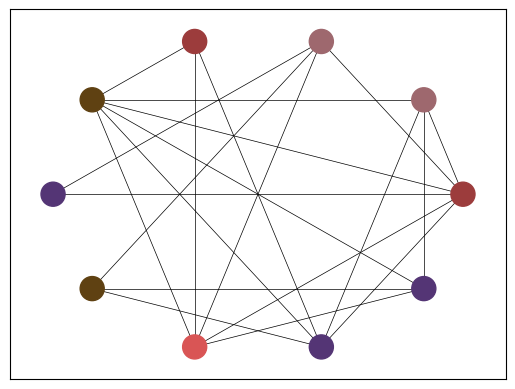

In [123]:
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions,
options=options, bounds=bounds)

cost, pos = optimizer.optimize(f, iters=100)

# rounding up solution values to get integers
pos = [int(el) for el in pos] 

graph_draw(pos, g.edges)

**The algorithm has succeeded!**

### Checking efficiency and elapsed time for PSO

In [124]:
# placeholders for measured times of solution finding 
pso_small_times = []
pso_medium_times = []
pso_large_times = []

# lists of indices of properly coloured graphs in each of the group
pso_s_good_ind = []
pso_m_good_ind = []
pso_l_good_ind = []

Small graphs

In [125]:
n_particles = 30
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# the number of dimensions of the optimizer has to be equal to the number of vertices that the graph has
dimensions = len(g_small[0].nodes) 

# defining bounds for the space
# the minimal color index can be 0, and the maximal 19 
x_min = np.zeros(dimensions)
x_max = np.array([19 for i in range(dimensions)])
my_bounds = (x_min, x_max)
bounds=my_bounds


for i in range(100):
    g = g_small[random.choice([0,1,2])]

    optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions,
                options=options, bounds=bounds)

    start = time.time()
    cost, pos = optimizer.optimize(f, iters=1000, verbose = 0)
    end = time.time()
    
    pso_small_times.append(end - start)
    
    # rounding up solution values to get integers
    pos = [int(el) for el in pos] 
    
    # fetching number of wrongly coloured vertices
    w_con, u_col = punishments(g.edges, g.nodes, pos)
    
    if w_con == 0: pso_s_good_ind.append(i)
        
print('Number of properly colours graphs: ',len(pso_s_good_ind),' out of 100.')

Number of properly colours graphs:  100  out of 100.


Medium graphs

In [126]:
n_particles = 30
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# the number of dimensions of the optimizer has to be equal to the number of vertices that the graph has
dimensions = len(g_medium[0].nodes)

# defining bounds for the space
# the minimal color index can be 0, and the maximal 19 
x_min = np.zeros(dimensions)
x_max = np.array([19 for i in range(dimensions)])
my_bounds = (x_min, x_max)
bounds=my_bounds


for i in range(100):
    g = g_medium[random.choice([0,1,2])]

    optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions,
                options=options, bounds=bounds)

    start = time.time()
    cost, pos = optimizer.optimize(f, iters=1000, verbose = 0)
    end = time.time()
    
    pso_medium_times.append(end - start)
    
    # rounding up solution values to get integers
    pos = [int(el) for el in pos] 
    
    # fetching number of wrongly coloured vertices
    w_con, u_col = punishments(g.edges, g.nodes, pos)
    
    if w_con == 0: pso_m_good_ind.append(i)
        
print('Number of properly colours graphs: ',len(pso_m_good_ind),' out of 100.')

Number of properly colours graphs:  100  out of 100.


Large graphs   
As before, the number of loop iterations here is set to 15.

In [127]:
n_particles = 30
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# the number of dimensions of the optimizer has to be equal to the number of vertices that the graph has
dimensions = len(g_large[0].nodes) 

# defining bounds for the space
# the minimal color index can be 0, and the maximal 19 
x_min = np.zeros(dimensions)
x_max = np.array([19 for i in range(dimensions)])
my_bounds = (x_min, x_max)
bounds=my_bounds


for i in range(15):
    g = g_large[random.choice([0,1,2])]

    optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions,
                options=options, bounds=bounds)

    start = time.time()
    cost, pos = optimizer.optimize(f, iters=1000, verbose = 0)
    end = time.time()
    
    pso_large_times.append(end - start)
    
    # rounding up solution values to get integers
    pos = [int(el) for el in pos] 
    
    # fetching number of wrongly coloured vertices
    w_con, u_col = punishments(g.edges, g.nodes, pos)
    
    if w_con == 0: pso_l_good_ind.append(i)
        
print('Number of properly colours graphs: ',len(pso_l_good_ind),' out of 15.')

Number of properly colours graphs:  0  out of 15.


As seen above, none of the algorithms have solved the problem. This could be caused by having not enough time to learn, or badly set parameters.    
Seeing the cost plot of the last considered graph could shed some light on that matter.   

<AxesSubplot:title={'center':'Cost History'}, xlabel='Iterations', ylabel='Cost'>

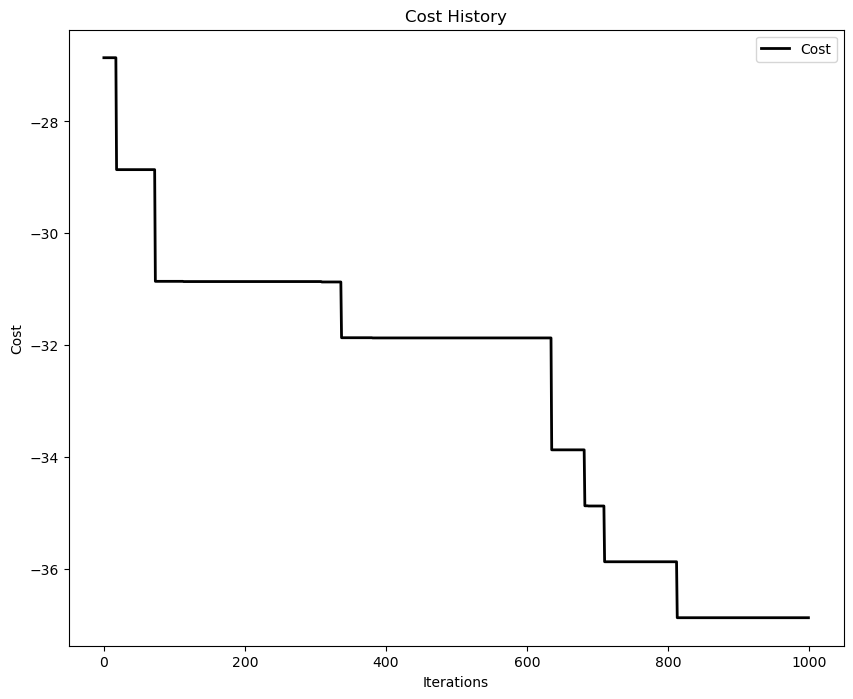

In [128]:
cost_history = optimizer.cost_history

ps.utils.plotters.plot_cost_history(cost_history)

The algorithms seem to keep improving, so it may be the case of the parameters.

#### Analysis of both algorithms computing efficiency
Since PSO models haven't solved any of the large graph problems, general elapsed times for these algorithms will be taken into consideration, instead of times taken to reach solutions.

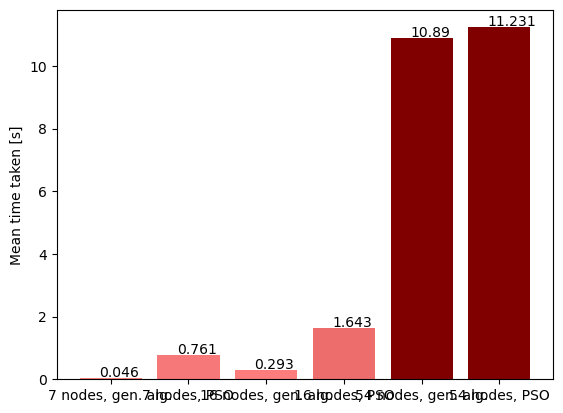

In [132]:
plt.figure()

# fetching times of algorithm instances that properly coloured the graphs
pso_g_small_times =[pso_small_times[ind] for ind in pso_s_good_ind]
pso_g_medium_times = [pso_medium_times[ind] for ind in pso_m_good_ind]
pso_g_large_times = [pso_large_times[ind] for ind in pso_l_good_ind]

# getting mean values of them
pso_times_means = [np.mean(pso_g_small_times), np.mean(pso_g_medium_times), np.mean(pso_large_times)]

# assembling all mean times
all_times_means = [times_means[0], pso_times_means[0],
                   times_means[1], pso_times_means[1],
                   times_means[2], pso_times_means[2]]

# creating ticks for the bars
ticks = [str(s_v)+' nodes, gen. alg.', str(s_v)+' nodes, PSO', 
         str(m_v)+' nodes, gen. alg.', str(m_v)+' nodes, PSO',
         str(l_v)+' nodes, gen. alg.', str(l_v)+' nodes, PSO']

plt.bar(ticks, all_times_means, align="center",
    color=color_map(data_normalizer(all_times_means)))
plt.ylabel('Mean time taken [s]')
for i in range(6):
    plt.annotate(str(round(all_times_means[i],3)), (i-.15, all_times_means[i]+.05))